In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
import random
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [2]:
#discount factor for future utilities
γ = 0.99

#number of episodes to run
NUM_EPISODES = 100

#max steps per episode
MAX_STEPS = 5000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#Lambda weight decay constant
λ = 0.3

#actor learning rate
αu = 0.001

#critic/gtd learning rate
αv = 0.005
αw = 0.001

In [3]:
#Stationary behavior policy
class BehavioralPolicy():
    
    #takes in distribution of action space
    def __init__(self, distribution):
        self.distribution = distribution
    
    #get probability of action given state
    def __call__(self, action, state):
        prob = self.distribution[action]
        
        return prob
    
    #sample an action under behavior distribution
    def choose_action(self, xs):
        m = Categorical(self.distribution)
        action = m.sample()
        
        return action.item()

In [4]:
#Target policy 
class TargetPolicy():
    
    #initialize with policy parameters
    def __init__(self, weight_vector):
        self.u = weight_vector
        
    #get probability of action given state
    def __call__(self, action, xs):
        
        #get distribution for current state
        distribution = mult(self.u, xs)
        
        #take softmax of distribution so its a probability [0, 1]
        softmax = F.softmax(distribution, dim=0)
        
        #return probability of action
        return softmax[action]
    
    #sample an action under target policy 
    def choose_action(self, xs):
        
        #get distribution
        distribution = mult(self.u, xs)
        
        #take softmax of distribution so its a probability [0, 1]
        softmax_dist = F.softmax(distribution, dim=0).squeeze(1)
        
        #sample action
        m = Categorical(softmax_dist)
        action = m.sample()

        return action.item()
        

In [5]:
#learned value function
class ValueFunction():
    
    #initialize with value function parameters
    def __init__(self, weight_vector):
        self.v = weight_vector
        
    #get value of given state
    def __call__(self, xs):
        val = mult(self.v, xs)
        
        return val

In [6]:
def mult(weight_vector, feature_vector):
    ''' Mulitplies weight vector by feature vector
    Args:
    - weight_vector (Tensor): vector of weights
    - feature_vector (Tensor): vector of features
    
    Return:
    - product (Tensor): product of vectors
    
    '''
    
    #Transpose weight vector and multiply by feature vector
    product = torch.matmul(torch.transpose(weight_vector, 0, 1), feature_vector)
    
    #Return product
    return product

In [48]:
#Make environment
env = gym.make('CartPole-v1').env

#env attributes
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n


#set seeds
np.random.seed(43)
random.seed(43)
env.seed(43)
torch.manual_seed(43)


#Init weight vectors, should be matrices of dimensions (input, output)
stdv = 1 / np.sqrt(obs_space)
u = torch.Tensor(np.random.uniform(low=-stdv, high=stdv, size=(obs_space, action_space))).to(DEVICE)
u.requires_grad = True
v = torch.Tensor(np.random.uniform(low=-stdv, high=stdv, size=(obs_space, 1))).to(DEVICE)

#Init trace vectors, should be same size as weight vectors
eu = torch.Tensor(np.zeros((obs_space, action_space))).to(DEVICE)
ev = torch.Tensor(np.zeros((obs_space, 1))).to(DEVICE)
w = torch.Tensor(np.zeros((obs_space, 1))).to(DEVICE)

#Init Behavior function, policy function, value function
b = BehavioralPolicy(torch.Tensor(np.full(action_space, 1/action_space)).to(DEVICE))
π = TargetPolicy(u)
V = ValueFunction(v)


#Note that we aren't initializing optimizers because we will be manually doing the update instead so we can use trace

In [49]:
scores = []

#iterate through episodes
for episode in tqdm_notebook(range(NUM_EPISODES*10)):
    
    #init variables
    state = env.reset()
    done = False
    score = 0
    
    #iterate through episode
    for step in range(MAX_STEPS):
        #env.render()
        
        #choose action a following b
        a = b.choose_action(state)
        
        #take step with action a 
        new_state, r, done, _ = env.step(a)
        
        #track reward
        score += r
        
        #convert states to tensors
        xs = torch.from_numpy(state).float().unsqueeze(1).to(DEVICE)
        
        xs_new = torch.from_numpy(new_state).float().unsqueeze(1).to(DEVICE)
        
        #calculate TD error
        δ = r + γ * mult(V.v, xs) - mult(V.v, xs_new)
        
        #calculate importance weight
        ρ = π(a, xs).item() / b(a, xs).item()
        
        #GTD(λ) algorithm:
        
        #update critic trace
        ev = ρ * (xs + γ * λ * ev)
        
        #update critic weight vector
        V.v = V.v + αv * (δ * ev - γ * (1-λ) * mult(w, xs) * xs)
        
        #update critic w trace
        w = w + αw * (δ * ev - mult(w, xs) * xs)
        
        #update actor trace and actor parameters:
        
        #calculate gradients of π(a|s)
        π(a, xs).backward()
        
        #calculate log probability of π(a|s)
        ψ = π.u.grad / π(a, xs)

        #update actor trace
        eu = ρ * (ψ.detach() + γ * λ * eu.detach())

        #update actor weight vector. Here we use detach so π.u is still a leaf tensor
        π.u = π.u.detach() + αu * δ * eu.detach()
        π.u.requires_grad = True
        
        if done:
            break
        
        #transition to new state
        state = new_state
    
    #track episode score
    scores.append(score)

env.close()

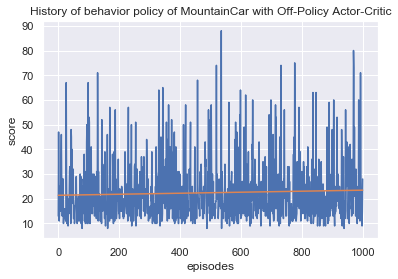

In [50]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

graphed_arr = scores

plt.plot(graphed_arr)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('History of behavior policy of MountainCar with Off-Policy Actor-Critic')

reg = LinearRegression().fit(np.arange(len(graphed_arr)).reshape(-1, 1), np.array(graphed_arr).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(graphed_arr)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [51]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    for _ in range(MAX_STEPS): 
        #env.render()
        xs = torch.from_numpy(state).float().unsqueeze(1).to(DEVICE)
        action = π.choose_action(xs)
        new_state, reward, done, info = env.step(action)
        score += reward
        
        if done:
            break
            
        state = new_state
    scores.append(score)
env.close()

In [52]:
np.array(scores).mean()

25.78

In [33]:
env.close()